## Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchaudio

import yt_dlp
import subprocess

import os
import pickle
import gc
import json
import locale
import re
import tqdm.notebook as tqdm
from urllib.parse import urlparse
import requests
import math

import av
from huggingface_hub import hf_hub_download
from typing import Callable

from transformers import VivitImageProcessor, VivitModel
from transformers import AutoImageProcessor, VideoMAEModel
from transformers import TimesformerConfig, TimesformerModel
from transformers import XCLIPProcessor, XCLIPModel
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from transformers import BitsAndBytesConfig, LlavaNextVideoForConditionalGeneration, LlavaNextVideoProcessor
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline

import librosa
from moviepy.editor import VideoFileClip
import ast
import openunmix

from minio import Minio
from minio.error import S3Error

import hydra
import soundfile as sf
from omegaconf import OmegaConf

import logging
from typing import List

import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import NCA

locale.getpreferredencoding = lambda: "UTF-8"

logging.basicConfig(
    filename='vivit_inference.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

Константы

In [2]:
CATEGORIES_ENG = """Auto-moto,
Anime,
Audiobooks,
Business,
Video games,
Interview,
Art,
Movie,
Beauty,
Cooking,
Life Hacks,
Music,
Cartoons,
News,
Training,
Hunting and fishing,
Politics,
Psychology,
Journeys,
Serials,
Sport,
Humor,
Lifestyle,
Realty,
Health,
Nature,
Design,
Machinery and equipment,
Business and entrepreneurship,
Culture,
Religion,
Construction and renovation,
Garden and vegetable garden,
Food,
Entertainment,
Esotericism,
The science,
Audio,
Technology and the Internet,
TV shows,
For children,
Hobby,
Various,
Animals,
News and media,
Films,
Bloggers,
"""

CATEGORIES_RUS = """
Авто-мото
Аниме
Аудиокниги
Бизнес
Видеоигры
Интервью
Искусство
Кино
Красота
Кулинария
Лайфхаки
Музыка
Мультфильмы
Новости
Обучение
Охота_и_рыбалка
Политика
Психология
Путешествия
Сериалы
Спорт
Юмор
Лайфстайл
Недвижимость
Здоровье
Природа
Дизайн
Техника_и_оборудование
Бизнес_и_предпринимательство
Культура
Религия
Строительство_и_ремонт
Сад_и_огород
Еда
Развлечения
Эзотерика
Наука
Аудио
Технологии_и_интернет
Телепередачи
Детям
Хобби
Разное
Животные
Новости_и_СМИ
Фильмы
Блогеры
"""


RUS_TEXT_PROMPT = [
    f"Видео принадлежит категории '{x}'" for x in CATEGORIES_RUS.split() if x.strip() != ''
]
ENG_TEXT_PROMPT = [
    f"Video belongs to category '{x}'" for x in CATEGORIES_ENG.split(',\n') if x.strip() != ''
]

## Вспомогательный код

In [3]:
client = Minio(
    endpoint="storage.yandexcloud.net",
    access_key="YCAJESQqZUja9X-F1glArEPSY",
    secret_key="YCP6M_QUdKUF1XBlgz_hOWAlTkcMbnEUyLG5hsQv",
)

BUCKET_NAME = "rutube-tagging"


def list_files_in_bucket(bucket_name=BUCKET_NAME):
    """
    List all files in the S3 bucket.
    """
    try:
        objects = client.list_objects(bucket_name)
        for obj in objects:
            print(obj.object_name)
    except S3Error as e:
        print(f"Error listing objects in bucket: {e}")


def download_video_from_s3_url(url, output_directory='.'):
    """
    Downloads a video from an S3-compatible URL using the MinIO client.
    
    :param url: The S3 URL of the video to download.
    :param output_directory: The directory where the video will be saved.
    """
    try:
        # Parse the URL to extract bucket and object name
        parsed_url = urlparse(url)
        path_parts = parsed_url.path.lstrip('/').split('/', 1)
        
        if len(path_parts) != 2:
            raise ValueError("URL does not contain both bucket and object name.")
        
        bucket_name, object_name = path_parts
        
        # Ensure the output directory exists
        os.makedirs(output_directory, exist_ok=True)
        
        # Define the local file path
        filename = os.path.basename(object_name)
        local_file_path = os.path.join(output_directory, filename)
        
        print(f"Starting download of {url} using MinIO client...")
        
        # Download the object
        client.fget_object(
            bucket_name, object_name, local_file_path
        )
        
        print(f"Download completed. Saved to {local_file_path}")
    
    except S3Error as e:
        print(f"S3 error occurred: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


def download_video_from_url(url, output_directory='.'):
    """
    Downloads a video from the given URL to the specified output directory.
    
    :param url: The URL of the video to download.
    :param output_directory: The directory where the video will be saved.
    """
    try:
        # Ensure the output directory exists
        os.makedirs(output_directory, exist_ok=True)
        
        # Extract the filename from the URL
        filename = os.path.basename(url)
        local_file_path = os.path.join(output_directory, filename)
        
        print(f"Starting download of {url}...")
        
        # Stream the download to handle large files
        with requests.get(url, stream=True) as response:
            response.raise_for_status()  # Check for HTTP errors
            with open(local_file_path, 'wb') as f:
                for chunk in tqdm.tqdm(response.iter_content(chunk_size=8192)):
                    if chunk:  # Filter out keep-alive chunks
                        f.write(chunk)
        
        print(f"Download completed. Saved to {local_file_path}")
    
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred while downloading {url}: {http_err}")
    except Exception as err:
        print(f"An error occurred while downloading {url}: {err}")

In [4]:
np.random.seed(0)
torch.manual_seed(0)


def get_model_params_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def sample_frame_indices(desired_frames: int, frame_sample_rate: int, total_frames: int) -> np.ndarray:
    indices = np.arange(0, frame_sample_rate*desired_frames, frame_sample_rate)
    if indices[-1] >= total_frames:
        indices = np.clip(indices, 0, total_frames-1)

    return indices


def read_video_pyav(container: av.container.input.InputContainer, indices: List[int]) -> np.ndarray:
    from collections import Counter
    
    frames = []
    container.seek(0)
    indices_dct = Counter(indices)
    
    max_idx = indices[-1]
    
    for i, frame in enumerate(container.decode(video=0)):
        if i > max_idx:
            break
        
        if i in indices_dct:
            while indices_dct[i] > 0:
                frames.append(frame)
                indices_dct[i] -= 1
    
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def process_video(
    video_path: str, 
    image_processor, 
    model,
    device: str = 'cuda',
    desired_frames: int = 96,
    window_size: int = 32,
    xclip_text_prompt: list = RUS_TEXT_PROMPT
) -> torch.Tensor:
    """
    Processes a Rutube video: extracts the first two minutes, samples 96 frames,
    and returns the ViViT model's output.

    :param video_path: Path to the video file.
    :param window_size: Size of each window for ViViT.
    :return: Model's output tensor.
    """
    assert desired_frames % window_size == 0
    
    try:
        # Open video with PyAV
        container = av.open(video_path)
        video_stream = container.streams.video[0]
        
        # Get total frames
        total_frames = video_stream.frames
        if total_frames == 0:
            duration = float(video_stream.duration * video_stream.time_base)
            fps = float(video_stream.average_rate)
            total_frames = int(duration * fps)
        else:
            fps = float(video_stream.average_rate)
            duration = float(video_stream.duration * video_stream.time_base)
        
        # Determine target duration (first minute or actual duration)
        target_duration = min(60, duration)  # seconds
        
        # Calculate frame_sample_rate and frame indices, read sampled frames
        frame_sample_rate = max(1, int(math.floor((fps * target_duration) / desired_frames)))
        indices = sample_frame_indices(desired_frames, frame_sample_rate, total_frames)
        video_frames = read_video_pyav(container, indices)
        
        if len(video_frames) == 0:
            raise ValueError("No frames were extracted from the video.")
        
        # Process inputs with image_processor
        if isinstance(model, XCLIPModel):
            inputs = image_processor(
                text=xclip_text_prompt,
                videos=list(video_frames),
                return_tensors="pt",
                padding=True,
                max_length=1024
            )
        else:
            inputs = image_processor(
                list(video_frames),
                return_tensors="pt",
                padding=True
            )
        inputs['pixel_values'] = torch.concat(torch.split(inputs['pixel_values'], window_size, dim=1))
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Extract desired output
        if hasattr(outputs, 'pooler_output'):
            output = outputs.pooler_output.mean(dim=0).cpu()
            return output
        elif hasattr(outputs, 'last_hidden_state'):
            output = outputs.last_hidden_state.mean(dim=[0, 1]).cpu()
            return output
        elif isinstance(model, XCLIPModel):
            probs = outputs.logits_per_video.cpu().squeeze().softmax(dim=-1)
            video_emb = outputs.video_embeds.cpu().squeeze()
            return video_emb, probs
        else:
            raise AttributeError("Model output does not contain 'pooler_output' or 'last_hidden_state'.")
        
        return output

    except Exception as e:
        logging.error(f"Unexpected error: {e}")
        print("An unexpected error occurred:")
        print(e)


def instantiate_model(model_name: str, device: str = 'cuda'):
    if model_name == 'vivit':
        model = VivitModel.from_pretrained("models/vivit_model")
        image_processor = VivitImageProcessor.from_pretrained("models/vivit_image_processor")
        window_size = 32
    elif model_name == 'timesformer':
        model = TimesformerModel.from_pretrained("models/timesformer_model")
        image_processor = AutoImageProcessor.from_pretrained("models/timesformer_image_processor")
        window_size = 8
    elif model_name == 'videomae':
        model = VideoMAEModel.from_pretrained("models/videomae_model")
        image_processor = AutoImageProcessor.from_pretrained("models/videomae_image_processor")
        window_size = 16
    elif model_name == 'x-clip':
        model = XCLIPModel.from_pretrained("models/xclip_model")
        image_processor = XCLIPProcessor.from_pretrained("models/xclip_image_processor")
        window_size = 32
    else:
        raise ValueError(f"{model_name} is not supported, should be in ('vivit', 'timesformer', 'videomae', 'x-clip')")

    
    model = model.to(device)
    model.eval()

    return model, image_processor, window_size

## Calculate embeddings

### Save storage

In [5]:
class EmbeddingStorage:
    def __init__(self, labels=None, filenames=None, embeddings=None):
        """
        Initialize the EmbeddingStorage class.
        
        Args:
            labels (list or np.ndarray): An array of labels for the embeddings.
            filenames (list or np.ndarray): An array of filenames associated with the embeddings.
            embeddings (np.ndarray): A NumPy array containing all embeddings.
        """
        self.labels = np.array(labels) if labels is not None else np.array([])
        self.filenames = np.array(filenames) if filenames is not None else np.array([])
        self.embeddings = np.array(embeddings) if embeddings is not None else np.empty((0,))

    def add_embedding(self, label, filename, embedding):
        """
        Add a new embedding, along with its label and filename.
        
        Args:
            label (int or str): The label of the embedding.
            filename (str): The filename associated with the embedding.
            embedding (np.ndarray or torch.Tensor): The embedding to add (can be a NumPy array or Tensor).
        """
        if isinstance(embedding, np.ndarray):
            emb_array = embedding
        else:
            # Convert torch.Tensor to NumPy
            emb_array = embedding.cpu().numpy()
        
        # Append the new data
        self.labels = np.append(self.labels, label)
        self.filenames = np.append(self.filenames, filename)
        
        if self.embeddings.size == 0:
            self.embeddings = emb_array.reshape(1, -1)
        else:
            self.embeddings = np.vstack([self.embeddings, emb_array])

    def save_to_file(self, file_path):
        """
        Save the embeddings, labels, and filenames to a file (as .npz).
        
        Args:
            file_path (str): The path to save the .npz file.
        """
        np.savez(file_path, labels=self.labels, filenames=self.filenames, embeddings=self.embeddings)

    @classmethod
    def load_from_file(cls, file_path):
        """
        Load embeddings, labels, and filenames from a saved .npz file.
        
        Args:
            file_path (str): The path to the .npz file to load.
        
        Returns:
            EmbeddingStorage: An instance of EmbeddingStorage with loaded data.
        """
        data = np.load(file_path)
        return cls(labels=data['labels'], filenames=data['filenames'], embeddings=data['embeddings'])

    def get_embedding_by_filename(self, filename):
        """
        Retrieve an embedding by its associated filename.
        
        Args:
            filename (str): The filename to search for.
        
        Returns:
            np.ndarray: The corresponding embedding or None if not found.
        """
        if filename in self.filenames:
            idx = np.where(self.filenames == filename)[0][0]
            return self.embeddings[idx]
        else:
            return None

    def join_on_videoname(self, other_storage):
        """
        Join two EmbeddingStorage objects on the 'videoname' (filename). The embeddings will be stored as tuples.
        
        Args:
            other_storage (EmbeddingStorage): Another EmbeddingStorage object to join with.
        
        Returns:
            EmbeddingStorage: A new EmbeddingStorage object with merged data (embedding tuples).
        """
        # Find common filenames
        common_filenames = np.intersect1d(self.filenames, other_storage.filenames)
        
        # Initialize lists to store merged data
        merged_labels = []
        merged_filenames = []
        merged_embeddings = []
        
        for filename in common_filenames:
            # Get embeddings for the common filename from both storages
            idx_self = np.where(self.filenames == filename)[0][0]
            idx_other = np.where(other_storage.filenames == filename)[0][0]
            
            emb_self = self.embeddings[idx_self]
            emb_other = other_storage.embeddings[idx_other]
            
            # Store embeddings as a tuple
            merged_embedding = (emb_self, emb_other)
            
            # Get the label from the first storage (could be changed based on use case)
            merged_label = self.labels[idx_self]
            
            # Append to the merged data
            merged_labels.append(merged_label)
            merged_filenames.append(filename)
            merged_embeddings.append(merged_embedding)
        
        # Convert lists to numpy arrays
        merged_labels = np.array(merged_labels)
        merged_filenames = np.array(merged_filenames)
        merged_embeddings = np.array(merged_embeddings, dtype=object)
        
        # Return a new EmbeddingStorage instance with merged data
        return EmbeddingStorage(labels=merged_labels, filenames=merged_filenames, embeddings=merged_embeddings)

    def __len__(self):
        """
        Return the number of embeddings stored.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve the label, filename, and embedding by index.
        
        Args:
            idx (int): The index of the embedding to retrieve.
        
        Returns:
            tuple: A tuple containing (label, filename, embedding).
        """
        if idx >= len(self.labels):
            raise IndexError("Index out of range")
        return self.labels[idx], self.filenames[idx], self.embeddings[idx]

    def __repr__(self):
        return f"EmbeddingStorage(labels={len(self.labels)}, filenames={len(self.filenames)}, embeddings_shape={self.embeddings.shape})"

### Video

In [6]:
if 'mapping_df' in locals():
    del mapping_df

mapping_df = pd.read_csv('scraped_dataset.csv')

#### Upload rest of the videos

In [156]:
import os


data_dir = './data/'
directory = os.fsencode(data_dir)
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    fullpath = os.path.join(data_dir, filename)

    if os.path.isdir(fullpath):
        if len(os.listdir(fullpath)) <= 6:
            print(filename, len(os.listdir(fullpath)))

19.0_serials 6
embeddings 1
45.0_various 0
42.0_tv shows 1


In [155]:
def extract_s3_id(s3_url: str) -> str:
    if s3_url is np.nan:
        return ''
    
    last_backslash_idx = len(s3_url) - s3_url[::-1].find('/')
    return s3_url[last_backslash_idx:]


def remove_slashes(s: str) -> str:
    if not isinstance(s, str):
        return ''

    chars_to_remove = [
        '/', '\\',            # Standard slashes
        "'", '"',             # Standard quotes
        '«', '»',             # Guillemets
        '“', '”',             # Curly double quotes
        '‘', '’',             # Curly single quotes
        '＂',                 # Fullwidth double quote
        '⧸',                   # Slash-like character
        '｜', '│',            # Vertical bar-like characters
        # Add any other auxiliary characters as needed
    ]

    translation_table = str.maketrans('', '', ''.join(chars_to_remove))
    cleaned_string = s.translate(translation_table)
    cleaned_string = re.sub(r'\s+', ' ', cleaned_string).strip()
    
    return cleaned_string


CATEGORIES_TO_UPLOAD = [
    "48.0_films",
    "19.0_serials",
    "7.0_movie",
    "29.0_design",
    "46.0_animals",
    "45.0_various",
    "5.0_interview",
    "42.0_tv shows",
    "35.0_garden and vegetable garden",
]

mapping_df = pd.read_csv('scraped_dataset.csv')
mapping_df['s3_name'] = mapping_df['s3_url'].apply(extract_s3_id)
mapping_df['video_name'] = mapping_df['parsed_category'].apply(lambda tuple_str: ast.literal_eval(tuple_str)[0])
mapping_df.dropna(subset=['video_name'], inplace=True)

data_dir = './data/'

for cat in tqdm.tqdm(CATEGORIES_TO_UPLOAD):
    ctg_id = extract_category_id(cat)
    df_slice = mapping_df.query(f"manual_category_id == {ctg_id}")

    subdir_name = os.path.join(data_dir, cat)
    downloaded_videos = list(map(remove_slashes, os.listdir(subdir_name)))

    for id, row in df_slice.iterrows():
        video_name = remove_slashes(row['video_name'])

        if video_name + '.mp4' not in downloaded_videos:
            download_video_from_url(row['s3_url'], subdir_name)
            # print(row['url'], subdir_name)
            # download_rutube_video_first_two_minutes(row['url'], subdir_name)


  0%|          | 0/7 [00:00<?, ?it/s]

Starting download of https://storage.yandexcloud.net/rutube-tagging/706ad097359f7cc6d007701d551b7679.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/7.0_movie/706ad097359f7cc6d007701d551b7679.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/2e1ecf3e724fa17ab80c1bab94f4f7cf.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/7.0_movie/2e1ecf3e724fa17ab80c1bab94f4f7cf.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/b32a625ab469910d422d362112c0f659.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/7.0_movie/b32a625ab469910d422d362112c0f659.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/37cf3b59bf1037d482dcd152725739a5.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/7.0_movie/37cf3b59bf1037d482dcd152725739a5.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/2a80727d7775e95da024c6649cf77ff4.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/7.0_movie/2a80727d7775e95da024c6649cf77ff4.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/7e2fec947c047fbdd5ee34196dc26a83.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/29.0_design/7e2fec947c047fbdd5ee34196dc26a83.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/1c09f1decadc5696e91700730fb2f85d.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/46.0_animals/1c09f1decadc5696e91700730fb2f85d.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/e7fb421c213fa05a74779d8b79a55070.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/5.0_interview/e7fb421c213fa05a74779d8b79a55070.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/56fdf9fab27b203aff343e69451405a1.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/5.0_interview/56fdf9fab27b203aff343e69451405a1.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/bf67ce3c647370f8d513ca28dfaecff8.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/5.0_interview/bf67ce3c647370f8d513ca28dfaecff8.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/dbf3b7dba2d74659c299746899406cd0.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/5.0_interview/dbf3b7dba2d74659c299746899406cd0.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/cd29049f5b1c065d5f59e223462c83ba.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/5.0_interview/cd29049f5b1c065d5f59e223462c83ba.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/5a50148a275752f6dd325e22a2ce6de3.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/5.0_interview/5a50148a275752f6dd325e22a2ce6de3.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/b982617423683652656ccb0715157d8a.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/5.0_interview/b982617423683652656ccb0715157d8a.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/8f43be0a7ec2fe5eb8c43981521b025d.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/35.0_garden and vegetable garden/8f43be0a7ec2fe5eb8c43981521b025d.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/74a8124af5c356afa01ac5311a2ebdca.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/35.0_garden and vegetable garden/74a8124af5c356afa01ac5311a2ebdca.mp4
Starting download of https://storage.yandexcloud.net/rutube-tagging/1fe3c8798c93a1836580941cd386bebd.mp4...


0it [00:00, ?it/s]

Download completed. Saved to ./data/35.0_garden and vegetable garden/1fe3c8798c93a1836580941cd386bebd.mp4


#### Inference ViViT

In [8]:
def extract_category_id(ctgry: str) -> int:
    return int(float(ctgry[:3]))


DATA_DIR = './data/tag_video/videos'
model_name = 'vivit'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, processor, window_size = instantiate_model(model_name, device)
embeddings_vivit = []

for video_file in tqdm.tqdm(os.listdir(DATA_DIR)):
    file_path = os.path.join(DATA_DIR, video_file)

    if not file_path.lower().endswith('.mp4'):
        continue
    
    output = process_video(file_path, processor, model, device, desired_frames=96, window_size=window_size)
    
    if output is not None:
        logging.info(f"Successfully processed video: {video_file}")
        embeddings_vivit.append((video_file, 0, output.numpy()))
    else:
        logging.warning(f"Failed to process video: {video_file}")

vivit_df = EmbeddingStorage(
    filenames=list(map(lambda x: x[0], embeddings_vivit)),
    labels=list(map(lambda x: x[1], embeddings_vivit)),
    embeddings=list(map(lambda x: x[2], embeddings_vivit)),
)
vivit_df.save_to_file('data/new_embeddings/vivit.npz')

# vivit_df = pd.DataFrame(data=embeddings_vivit, columns=['videoname', 'label', 'emb'])
# vivit_df.to_csv('data/embeddings/vivit.csv', index=False)

  0%|          | 0/1049 [00:00<?, ?it/s]

#### Inference X-CLIP

In [9]:
del model, processor
torch.cuda.empty_cache()

In [11]:
DATA_DIR = './data/tag_video/videos'
model_name = 'x-clip'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, processor, window_size = instantiate_model(model_name, device)
embeddings_xclip = []

for video_file in tqdm.tqdm(os.listdir(DATA_DIR)):
    file_path = os.path.join(DATA_DIR, video_file)

    if not file_path.lower().endswith('.mp4'):
        continue

    output = process_video(file_path, processor, model, device, desired_frames=96, window_size=window_size)
    
    if output is not None:
        logging.info(f"Successfully processed video: {video_file}")
        embeddings_xclip.append((video_file, 0, output[0].numpy(), output[1].numpy()))
    else:
        logging.warning(f"Failed to process video: {video_file}")

xclip_emb_df = EmbeddingStorage(
    filenames=list(map(lambda x: x[0], embeddings_xclip)),
    labels=list(map(lambda x: x[1], embeddings_xclip)),
    embeddings=list(map(lambda x: x[2], embeddings_xclip)),
)
xclip_emb_df.save_to_file('data/new_embeddings/xclip_emb.npz')

xclip_prob_df = EmbeddingStorage(
    filenames=list(map(lambda x: x[0], embeddings_xclip)),
    labels=list(map(lambda x: x[1], embeddings_xclip)),
    embeddings=list(map(lambda x: x[3], embeddings_xclip)),
)
xclip_prob_df.save_to_file('data/new_embeddings/xclip_prob.npz')

# xclip_df = pd.DataFrame(data=embeddings_xclip, columns=['videoname', 'label', 'emb', 'prob'])
# xclip_df.to_csv('data/embeddings/xclip.csv', index=False)

  0%|          | 0/1049 [00:00<?, ?it/s]

#### Inference Video-MAE

In [12]:
del model, processor
torch.cuda.empty_cache()

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
def extract_category_id(ctgry: str) -> int:
    return int(float(ctgry[:3]))


DATA_DIR = './data/tag_video/videos'
model_name = 'videomae'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, processor, window_size = instantiate_model(model_name, device)
embeddings_videomae = []

for video_file in tqdm.tqdm(os.listdir(DATA_DIR)):
    file_path = os.path.join(DATA_DIR, video_file)

    if not file_path.lower().endswith('.mp4'):
        continue
    
    output = process_video(file_path, processor, model, device, desired_frames=96, window_size=window_size)
    
    if output is not None:
        logging.info(f"Successfully processed video: {video_file}")
        embeddings_videomae.append((video_file, 0, output.numpy()))
    else:
        logging.warning(f"Failed to process video: {video_file}")

videomae_df = EmbeddingStorage(
    filenames=list(map(lambda x: x[0], embeddings_videomae)),
    labels=list(map(lambda x: x[1], embeddings_videomae)),
    embeddings=list(map(lambda x: x[2], embeddings_videomae)),
)
videomae_df.save_to_file('data/new_embeddings/videomae.npz')

# videomae_df = pd.DataFrame(data=embeddings_videomae, columns=['videoname', 'label', 'emb'])
# videomae_df.to_csv('data/embeddings/videonae.csv', index=False)

  0%|          | 0/1049 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Audio

#### Auxiliary functions

In [ ]:
def extract_audio_from_video(video_path, output_audio_path="temp_audio.wav", duration=60):
    video_clip = VideoFileClip(video_path)

    if video_clip is None:
        return None
    elif video_clip.audio is None:
        video_clip.close()
        return None
    
    audio_clip = video_clip.audio.subclip(0, min(duration, video_clip.duration))
    audio_clip.write_audiofile(output_audio_path, codec='pcm_s16le', ffmpeg_params=['-ac', '1'])
    
    # Close the clip to release resources
    video_clip.close()
    audio_clip.close()
    
    return output_audio_path


def speech_file_to_array_fn(batch, duration: int, sampling_rate: int):
    # Extract the audio from the mp4 file
    audio_path = extract_audio_from_video(batch["path"], duration=duration)

    if audio_path is None:
        return None

    # Load the extracted audio using librosa
    speech_array, sampling_rate = librosa.load(audio_path, sr=sampling_rate)

    # Prepare for Wav2Vec2 inference
    batch["speech"] = speech_array
    return batch


def extract_category_id(ctgry: str) -> int:
    return int(float(ctgry[:3]))


class SpecScaler(torch.nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.log(x.clamp_(1e-9, 1e9))


def instantiate_giga_am(dirname: str, device: str):
    encoder_config = dirname+"encoder_config.yaml"
    model_weights = dirname+"ssl_model_weights.ckpt"
    conf = OmegaConf.load(encoder_config)
    
    encoder = hydra.utils.instantiate(conf.encoder)
    ckpt = torch.load(model_weights, map_location="cpu")
    encoder.load_state_dict(ckpt, strict=True)
    encoder.to(device)
    encoder.eval()
    
    feature_extractor = hydra.utils.instantiate(conf.feature_extractor)

    return encoder, feature_extractor


def process_gigaam(
    video_path: str,
    encoder,
    feature_extractor,
    device,
    audio_duration: int = 60,
    audio_sampling_rate: int = 16000
) -> torch.Tensor:    
    try:
        test_sample = {"path": video_path}
        test_sample = speech_file_to_array_fn(test_sample, audio_duration, audio_sampling_rate)
        features = feature_extractor(torch.tensor(test_sample['speech']).float()).to(device)

        with torch.no_grad():
            encoded, _ = encoder.forward(
                audio_signal=features.unsqueeze(0),
                length=torch.tensor([features.shape[-1]]).to(device),
            )
        
        output = encoded.mean(dim=2).squeeze().cpu()
        return output

    except Exception as e:
        logging.error(f"Unexpected error: {e}")
        print("An unexpected error occurred:")
        print(e)

#### Inference Giga-AM

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder, feature_extractor = instantiate_giga_am('models/giga_am/', device)
embeddings_gigaam = []

for video_file in tqdm.tqdm(os.listdir(DATA_DIR)):
    file_path = os.path.join(DATA_DIR, video_file)

    if not file_path.lower().endswith('.mp4'):
        continue
    
    output = process_gigaam(file_path, encoder, feature_extractor, device)
    
    if output is not None:
        logging.info(f"Successfully processed video: {video_file}")
        embeddings_gigaam.append((video_file, 0, output.numpy()))
    else:
        logging.warning(f"Failed to process video: {video_file}")

gigaam_df = EmbeddingStorage(
    filenames=list(map(lambda x: x[0], embeddings_gigaam)),
    labels=list(map(lambda x: x[1], embeddings_gigaam)),
    embeddings=list(map(lambda x: x[2], embeddings_gigaam)),
)
gigaam_df.save_to_file('data/new_embeddings/gigaam.npz')

# gigaam_df = pd.DataFrame(data=embeddings_gigaam, columns=['videoname', 'label', 'emb'])
# gigaam_df.to_csv('data/embeddings/gigaam.csv', index=False)

#### Raw notes on GigaAM-RNNT

In [10]:
from nemo.collections.asr.models import EncDecRNNTBPEModel
from nemo.collections.asr.modules.audio_preprocessing import (
    AudioToMelSpectrogramPreprocessor as NeMoAudioToMelSpectrogramPreprocessor,
)
from nemo.collections.asr.parts.preprocessing.features import (
    FilterbankFeaturesTA as NeMoFilterbankFeaturesTA,
)

[NeMo W 2024-09-26 14:23:18 nemo_logging:349] /home/eduard/Рабочий стол/video-tagging/video-tag/lib/python3.10/site-packages/megatron/core/tensor_parallel/layers.py:254: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
      def forward(
    
[NeMo W 2024-09-26 14:23:18 nemo_logging:349] /home/eduard/Рабочий стол/video-tagging/video-tag/lib/python3.10/site-packages/megatron/core/tensor_parallel/layers.py:265: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
      def backward(ctx, grad_output):
    
[NeMo W 2024-09-26 14:23:18 nemo_logging:349] /home/eduard/Рабочий стол/video-tagging/video-tag/lib/python3.10/site-packages/megatron/core/tensor_parallel/layers.py:325: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
      

Download config, weights, tokenizer

In [6]:
# !wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/GigaAM/rnnt_model_weights.ckpt
# !wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/GigaAM/rnnt_model_config.yaml
# !wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/GigaAM/example.wav
# !wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/GigaAM/long_example.wav
# !wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/GigaAM/tokenizer_all_sets.tar
# !tar -xf tokenizer_all_sets.tar && rm tokenizer_all_sets.tar

Modules for feature Extraction

In [ ]:
class FilterbankFeaturesTA(NeMoFilterbankFeaturesTA):
    def __init__(self, mel_scale: str = "htk", wkwargs=None, **kwargs):
        if "window_size" in kwargs:
            del kwargs["window_size"]
        if "window_stride" in kwargs:
            del kwargs["window_stride"]

        super().__init__(**kwargs)

        self._mel_spec_extractor: torchaudio.transforms.MelSpectrogram = (
            torchaudio.transforms.MelSpectrogram(
                sample_rate=self._sample_rate,
                win_length=self.win_length,
                hop_length=self.hop_length,
                n_mels=kwargs["nfilt"],
                window_fn=self.torch_windows[kwargs["window"]],
                mel_scale=mel_scale,
                norm=kwargs["mel_norm"],
                n_fft=kwargs["n_fft"],
                f_max=kwargs.get("highfreq", None),
                f_min=kwargs.get("lowfreq", 0),
                wkwargs=wkwargs,
            )
        )


class AudioToMelSpectrogramPreprocessor(NeMoAudioToMelSpectrogramPreprocessor):
    def __init__(self, mel_scale: str = "htk", **kwargs):
        super().__init__(**kwargs)
        kwargs["nfilt"] = kwargs["features"]
        del kwargs["features"]
        self.featurizer = (
            FilterbankFeaturesTA(  # Deprecated arguments; kept for config compatibility
                mel_scale=mel_scale,
                **kwargs,
            )
        )

Inference example

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = EncDecRNNTBPEModel.from_config_file("./models/giga_am/rnnt_model_config.yaml")
ckpt = torch.load("./models/giga_am/rnnt_model_weights.ckpt", map_location="cpu")
model.load_state_dict(ckpt, strict=False)
model.eval()
model = model.to(device)

[NeMo I 2024-09-26 14:40:59 mixins:172] Tokenizer SentencePieceTokenizer initialized with 512 tokens


[NeMo W 2024-09-26 14:40:59 audio_to_text_dataset:830] Could not load dataset as `manifest_filepath` was None. Provided config : {'shuffle': False, 'manifest_filepath': None}


[NeMo I 2024-09-26 14:40:59 features:289] PADDING: 0
[NeMo I 2024-09-26 14:41:00 rnnt_models:217] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2024-09-26 14:41:00 nemo_logging:349] /tmp/ipykernel_206253/913905516.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
      ckpt = torch.load("./models/giga_am/rnn

In [39]:
with torch.no_grad():
    outp = model.transcribe(["./example.wav"])[0]
    print(outp)

with torch.no_grad():
    outp = model.transcribe(["./long_example.wav"])[0]
    print(outp)

with torch.no_grad():
    outp = model.transcribe(["./temp_audio.wav"])[0]
    print(outp)

file_path_1 = 'example.wav'
audio, sr = librosa.load(file_path_1, sr=None, mono=False)
print(audio.shape)

file_path_2 = 'long_example.wav'
audio, sr = librosa.load(file_path_2, sr=None, mono=False)
print(audio.shape)

file_path_3 = 'temp_audio.wav'
audio, sr = librosa.load(file_path_3, sr=None, mono=False)
print(audio.shape)

#### Inference Whisper-V3

In [ ]:
del encoder, feature_extractor
torch.cuda.empty_cache()

In [ ]:
def instantiate_whisper(device: str = 'cuda', torch_dtype = torch.float16):
    model = AutoModelForSpeechSeq2Seq.from_pretrained(
        "models/whisper_model", torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
    ).to(device)
    processor = AutoProcessor.from_pretrained("models/whisper_processor")
    
    model.eval()

    pipe = pipeline(
        "automatic-speech-recognition",
        model=model,
        tokenizer=processor.tokenizer,
        feature_extractor=processor.feature_extractor,
        torch_dtype=torch_dtype,
        device=device,
        chunk_length_s=30,
        stride_length_s=5
    )

    return model, processor, pipe


def process_whisper(
    video_path: str,
    model,
    processor,
    asr_pipe,
    device = 'cuda',
    torch_dtype = torch.float16,
    audio_duration: int = 60,
    audio_sampling_rate: int = 16000
) -> torch.Tensor:    
    try:
        inp_sample = {"path": video_path}
        test_sample = speech_file_to_array_fn(inp_sample, audio_duration, audio_sampling_rate)

        if test_sample is None:
            return None, None
        
        inputs = processor(test_sample['speech'], sampling_rate=audio_sampling_rate, return_tensors="pt")
        input_features = inputs.input_features.type(torch_dtype).to(device)

        with torch.no_grad():
            encoder_outputs = model.model.encoder(input_features)
        
        output = encoder_outputs.last_hidden_state.mean(dim=1).squeeze().cpu()
        
        sample = {'raw': test_sample['speech'], 'sampling_rate': audio_sampling_rate}
        decoded_speech = asr_pipe(sample)
        
        return output, decoded_speech['text']

    except Exception as e:
        logging.error(f"Unexpected error: {e}")
        print("An unexpected error occurred:")
        print(e)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model, processor, asr_pipe = instantiate_whisper(device, torch_dtype)
embeddings_whisper = []

for video_file in tqdm.tqdm(os.listdir(DATA_DIR)):
    file_path = os.path.join(DATA_DIR, video_file)

    if not file_path.lower().endswith('.mp4'):
        continue
    
    output, recov_text = process_whisper(file_path, model, processor, asr_pipe, device, torch_dtype)
    
    if output is not None:
        logging.info(f"Successfully processed video: {video_file}")
        embeddings_whisper.append((video_file, 0, output.numpy(), recov_text))
    else:
        logging.warning(f"Failed to process video: {video_file}")

whisper_df = EmbeddingStorage(
    filenames=list(map(lambda x: x[0], embeddings_whisper)),
    labels=list(map(lambda x: x[1], embeddings_whisper)),
    embeddings=list(map(lambda x: x[2], embeddings_whisper)),
)
whisper_df.save_to_file('data/new_embeddings/whisper.npz')

whisper_text_df = EmbeddingStorage(
    filenames=list(map(lambda x: x[0], embeddings_whisper)),
    labels=list(map(lambda x: x[1], embeddings_whisper)),
    embeddings=list(map(lambda x: x[3], embeddings_whisper)),
)
whisper_text_df.save_to_file('data/new_embeddings/whisper_text.npz')

# whisper_df = pd.DataFrame(data=embeddings_whisper, columns=['videoname', 'label', 'emb', 'text'])
# whisper_df.to_csv('data/embeddings/whisper.csv', index=False)

## Quality metrics

In [17]:
def top_k_accuracy(target: np.ndarray, preds: np.ndarray, k: int = 10) -> float:
    numer = 0
    denom = target.size
    
    for label, labels_set in zip(target, preds):
        if label in labels_set[:k]:
            numer += 1

    return numer * 1.0 / denom

def string_to_numpy(tensor_string):
    tensor_string = tensor_string.replace('tensor(', '').rstrip(')')
    tensor_data = ast.literal_eval(tensor_string)
    tensor = torch.tensor(tensor_data)
    
    return tensor

def string_to_numpy(tensor_string):
    tensor_string = tensor_string.replace('tensor(', '').rstrip(')')
    tensor_data = ast.literal_eval(tensor_string)
    tensor_numpied = torch.tensor(tensor_data).numpy()
    
    return tensor_numpied


label_data = [
    (0, 'Авто-мото'),
    (1, 'Аниме'),
    (2, 'Аудиокниги'),
    (3, 'Бизнес'),
    (4, 'Видеоигры'),
    (5, 'Интервью'),
    (6, 'Искусство'),
    (7, 'Кино'),
    (8, 'Красота'),
    (9, 'Кулинария'),
    (10, 'Лайфхаки'),
    (11, 'Музыка'),
    (12, 'Мультфильмы'),
    (13, 'Новости'),
    (14, 'Обучение'),
    (15, 'Охота и рыбалка'),
    (16, 'Политика'),
    (17, 'Психология'),
    (18, 'Путешествия'),
    (19, 'Сериалы'),
    (20, 'Спорт'),
    (22, 'Юмор'),
    (25, 'Лайфстайл'),
    (26, 'Недвижимость'),
    (27, 'Здоровье'),
    (28, 'Природа'),
    (29, 'Дизайн'),
    (30, 'Техника и оборудование'),
    (31, 'Бизнес и предпринимательство'),
    (32, 'Культура'),
    (33, 'Религия'),
    (34, 'Строительство и ремонт'),
    (35, 'Сад и огород'),
    (36, 'Еда'),
    (37, 'Развлечения'),
    (38, 'Эзотерика'),
    (39, 'Наука'),
    (40, 'Аудио'),
    (41, 'Технологии и интернет'),
    (42, 'Телепередачи'),
    (43, 'Детям'),
    (44, 'Хобби'),
    (45, 'Разное'),
    (46, 'Животные'),
    (47, 'Новости и СМИ'),
    (48, 'Фильмы'),
    (49, 'Блогеры')
]
label_df = pd.DataFrame(label_data, columns=['tag_id', 'tag'])

## X-CLIP

### No context

In [ ]:
tag_id_to_index

In [18]:
clip_df = pd.read_csv('data/embeddings/x-clip-v2.csv')
tag_id_to_index = dict(zip(label_df.tag_id, label_df.index))

Accuracy of first window

In [19]:
clip_id_label = clip_df.label.apply(lambda x: tag_id_to_index[x]).values
top_n_predictions = np.vstack(clip_df.probs.apply(lambda x: np.argsort(string_to_numpy(x))[0, :][::-1]))

print('Top 1 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 1) * 100)
print('Top 5 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 5) * 100)
print('Top 10 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 10) * 100)

Top 1 accuracy: 8.16831683168317
Top 5 accuracy: 19.554455445544555
Top 10 accuracy: 32.17821782178218


Accuracy of second window

In [21]:
clip_id_label = clip_df.label.apply(lambda x: tag_id_to_index[x]).values
top_n_predictions = np.vstack(clip_df.probs.apply(lambda x: np.argsort(string_to_numpy(x))[1, :][::-1]))

print('Top 1 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 1) * 100)
print('Top 5 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 5) * 100)
print('Top 10 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 10) * 100)

Top 1 accuracy: 9.158415841584159
Top 5 accuracy: 20.049504950495052
Top 10 accuracy: 31.18811881188119


Accuracy of third window

In [22]:
clip_id_label = clip_df.label.apply(lambda x: tag_id_to_index[x]).values
top_n_predictions = np.vstack(clip_df.probs.apply(lambda x: np.argsort(string_to_numpy(x))[2, :][::-1]))

print('Top 1 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 1) * 100)
print('Top 5 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 5) * 100)
print('Top 10 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 10) * 100)

Top 1 accuracy: 5.445544554455446
Top 5 accuracy: 20.049504950495052
Top 10 accuracy: 30.198019801980198


Accuracy of average window

In [24]:
clip_id_label = clip_df.label.apply(lambda x: tag_id_to_index[x]).values
top_n_predictions = np.vstack(clip_df.probs.apply(lambda x: np.argsort(string_to_numpy(x)).mean(axis=0)[::-1]))

print('Top 1 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 1) * 100)
print('Top 5 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 5) * 100)
print('Top 10 accuracy:', top_k_accuracy(clip_id_label, top_n_predictions, 10) * 100)

Top 1 accuracy: 3.9603960396039604
Top 5 accuracy: 6.9306930693069315
Top 10 accuracy: 10.891089108910892


### ~~Whisper huggingface context~~

We need to increase the maximum text size from 77 to 1024

So, we have to make some tricks

In [75]:
POSITION_EMB_SIZE = 1024


model, processor, window_size = instantiate_model(model_name, device)
model.text_model.config.max_position_embeddings = POSITION_EMB_SIZE

old_embedding = model.text_model.embeddings.position_embedding
embedding_dim = old_embedding.weight.shape[1]
new_embedding = nn.Embedding(POSITION_EMB_SIZE, embedding_dim).to(device)

# Initialize the new embeddings with the old embeddings
num_tokens_to_copy = min(old_embedding.weight.shape[0], POSITION_EMB_SIZE)
new_embedding.weight.data[:num_tokens_to_copy, :] = old_embedding.weight.data[:num_tokens_to_copy, :]

# Replace the model's position embeddings with the new embeddings
model.text_model.embeddings.position_embedding = new_embedding

processor.tokenizer.model_max_length = POSITION_EMB_SIZE

In [80]:
def extract_category_id(ctgry: str) -> int:
    return int(float(ctgry[:3]))


def extract_text_by_video_name(whisper_df: pd.DataFrame, videoname: str):
    if videoname not in whisper_df.videoname.values:
        print(f"Такого видео не существует: {videoname}")
        return None
    
    text = whisper_df[whisper_df.videoname == videoname]['text']

    if text is None or text is np.nan or text is pd.NA:
        return None
    else:
        return text.values[0]


def get_xclip_prompt_with_audio_context(whisper_df: pd.DataFrame, videoname: str):
    text = extract_text_by_video_name(whisper_df, videoname)

    if text is None:
        return RUS_TEXT_PROMPT
    else:
        return [f"Видео субтитры: '{text}'. " + x for x in RUS_TEXT_PROMPT]


def postprocess_model_and_processor(model, processor, device):
    POSITION_EMB_SIZE = 1024

    model, processor, window_size = instantiate_model(model_name, device)
    model.text_model.config.max_position_embeddings = POSITION_EMB_SIZE
    
    old_embedding = model.text_model.embeddings.position_embedding
    embedding_dim = old_embedding.weight.shape[1]
    new_embedding = nn.Embedding(POSITION_EMB_SIZE, embedding_dim).to(device)
    
    # Initialize the new embeddings with the old embeddings
    num_tokens_to_copy = min(old_embedding.weight.shape[0], POSITION_EMB_SIZE)
    new_embedding.weight.data[:num_tokens_to_copy, :] = old_embedding.weight.data[:num_tokens_to_copy, :]
    
    # Replace the model's position embeddings with the new embeddings
    model.text_model.embeddings.position_embedding = new_embedding
    processor.tokenizer.model_max_length = POSITION_EMB_SIZE

    return model, processor


DATA_DIR = './data'
model_name = 'x-clip'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, processor, window_size = instantiate_model(model_name, device)
model, processor = postprocess_model_and_processor(model, processor, device)
embeddings_xclip = []

whisper_df = pd.read_csv('data/embeddings/whisper.csv')

for data_subdir in tqdm.tqdm(os.listdir(DATA_DIR)):
    fullpath = os.path.join(DATA_DIR, data_subdir)

    if not os.path.isdir(fullpath):
        continue
    
    video_files = [f for f in os.listdir(fullpath) if f.lower().endswith('.mp4')]
    logging.info(f"Found {len(video_files)} video(s) in directory '{data_subdir}'.")
    
    for video_file in video_files:
        file_path = os.path.join(fullpath, video_file)
        output = process_video(
            file_path,
            processor,
            model,
            device,
            desired_frames=96,
            window_size=window_size,
            xclip_text_prompt=get_xclip_prompt_with_audio_context(whisper_df, video_file)
        )
        
        if output is not None:
            logging.info(f"Successfully processed video: {video_file}")
            embeddings_xclip.append((video_file, extract_category_id(data_subdir), output[0], output[1]))
        else:
            logging.warning(f"Failed to process video: {video_file}")

xclip_df = pd.DataFrame(data=embeddings_xclip, columns=['videoname', 'label', 'emb', 'probs'])
xclip_df.to_csv('data/embeddings/x-clip-whisper.csv', index=False)

  0%|          | 0/48 [00:00<?, ?it/s]

True torch.Size([47, 398]) torch.Size([3, 32, 3, 224, 224])
An unexpected error occurred:
The size of tensor a (398) must match the size of tensor b (77) at non-singleton dimension 1


RuntimeError: The size of tensor a (398) must match the size of tensor b (77) at non-singleton dimension 1

In [74]:
new_text_prompt = get_xclip_prompt_with_audio_context(whisper_df, "2d102489e381cb2dc28395d3a76771b1.mp4")
video_path = "./data/48.0_films/2d102489e381cb2dc28395d3a76771b1.mp4"

process_video(
    video_path,
    processor,
    model,
    device,
    xclip_text_prompt=new_text_prompt
)

True torch.Size([47, 398]) torch.Size([3, 32, 3, 224, 224])
An unexpected error occurred:
The size of tensor a (398) must match the size of tensor b (77) at non-singleton dimension 1


RuntimeError: The size of tensor a (398) must match the size of tensor b (77) at non-singleton dimension 1

### ~~Whisper API context~~

## PLS-DA

In [71]:
whisper_df = EmbeddingStorage.load_from_file('data/embeddings/whisper.npz')
xclip_df = EmbeddingStorage.load_from_file('data/embeddings/xclip_emb.npz')
xclip_df.embeddings = xclip_df.embeddings.mean(axis=1)

whisper_and_xclip_df = whisper_df.join_on_videoname(xclip_df)
whisper_values = np.vstack([elem[0] for elem in whisper_and_xclip_df.embeddings])
xclip_values = np.vstack([elem[1] for elem in whisper_and_xclip_df.embeddings])
labels = whisper_and_xclip_df.labels

In [ ]:
def run_pls(
        X1: np.ndarray,
        X2: np.ndarray,
        Y: np.ndarray,
        prediction_pipe: Callable,
        n_splits: int = 5,
        n_components_list: int = [4],
        seed: int = 42,
        normalize: bool = False
    ) -> dict:
    # Scale the embeddings before applying PLS
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    test_acc_1_ttl, test_acc_5_ttl = 0, 0

    for n_comp in tqdm(n_components_list): 
        for train_indices, test_indices in kf.split(np.arange(X1.shape[0]), Y):
            Y_train, Y_test = Y[train_indices], Y[test_indices]
            
            if normalize:
                scaler_X1 = StandardScaler()
                scaler_X2 = StandardScaler()
            
                X1_train_scaled = scaler_X1.fit_transform(X1[train_indices])
                X2_train_scaled = scaler_X2.fit_transform(X2[train_indices])
        
                X1_test_scaled = scaler.transform(X1[test_indices])
                X2_test_scaled = scaler.transform(X2[test_indices])
            else:
                X1_train_scaled = X1[train_indices]
                X2_train_scaled = X1[train_indices]
                
                X1_test_scaled = X1[test_indices]
                X2_test_scaled = X1[test_indices]
            
            pls = PLSRegression(n_components=n_components, normalize=False)
            pls.fit(X1_train_scaled, X2_train_scaled)
            
            X1_latent_train, X2_latent_train = pls.transform(X1_train_scaled, X2_train_scaled)
            X1_latent_test, X2_latent_test = pls.transform(X1_test_scaled, X2_test_scaled)
            
            latent_train = 0.5 * X1_latent_train + 0.5 * X2_latent_train
            latent_test = 0.5 * X1_latent_test + 0.5 * X2_latent_test
            
            clf_1 = make_pipeline(NCA(), KNeighborsClassifier())
            clf_2 = KNeighborsClassifier()
            clf_1.fit(latent_train, Y_train)
            clf_2.fit(latent_train, Y_train)
            
            clf_1_pred = np.argsort(-clf_1.predict_proba(latent_test), axis=1)[:, :5]
            clf_2_pred = np.argsort(-clf_2.predict_proba(latent_test), axis=1)[:, :5]
            
            test_acc_1, test_acc_5 = whisper_and_xclip_df
        
        print(f'CLF 1: Components: {n_comp}, ACC@1: {acc_1}, ACC@5: {acc_5}')
        print(f'CLF 2: Components: {n_comp}, ACC@1: {acc_1}, ACC@5: {acc_5}')
            
        return pls, mse, X1_latent, X2_latent

In [127]:
from metric_learn import NCA
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

X, y = load_iris(return_X_y=True)
clf = make_pipeline(NCA(), KNeighborsClassifier())

clf.fit(X, y)
# clf.predict(X).reshape(-1, 1)
top_n_classes = np.argsort(-clf.predict_proba(X), axis=1)[:, :2]

In [129]:
top_n_classes.shape

(150, 2)

In [102]:
X1 = whisper_values
X2 = xclip_values
Y = labels

# Train PLS model
pls = PLSRegression(n_components=2, scale=False)
pls.fit(X1, X2)

X1_latent, X2_latent = pls.transform(X1, X2)

In [105]:
np.corrcoef(X1_latent[:, 1], X2_latent[:, 1])

array([[1.        , 0.41061584],
       [0.41061584, 1.        ]])

<Axes: >

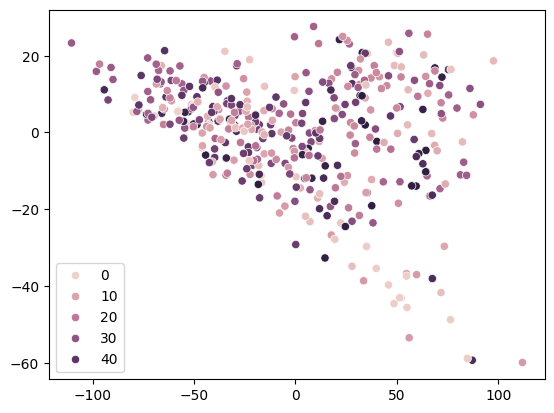

In [85]:
sns.scatterplot(x=X2_latent[:, 0], y=X2_latent[:, 1], hue=Y)

In [11]:
np.random.seed(42)
X = np.random.rand(n_samples, n_features)
y = np.random.randint(0, n_classes, n_samples)

# Binarize the labels (One-hot encoding)
label_binarizer = LabelaBinarizer()
Y_binarized = label_binarizer.fit_transform(y)

# If Y_binarized has only one column (binary classification), adjust shape
if Y_binarized.shape[1] == 1:
    Y_binarized = np.hstack((Y_binarized, 1 - Y_binarized))

# Split the data into training and testing sets
X_train, X_test, Y_train_binarized, Y_test_binarized, y_train, y_test = train_test_split(
    X, Y_binarized, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to perform cross-validation and find optimal number of components
def pls_da_cross_val(X, Y, y_labels, n_components_list):
    cv_scores = []
    for n_comp in n_components_list:
        pls = PLSRegression(n_components=n_comp)
        accuracies = []
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for train_index, val_index in skf.split(X, y_labels):
            X_train_cv, X_val_cv = X[train_index], X[val_index]
            Y_train_cv, Y_val_cv = Y[train_index], Y[val_index]
            y_val_cv = y_labels[val_index]

            pls.fit(X_train_cv, Y_train_cv)
            Y_pred_cv = pls.predict(X_val_cv)
            y_pred_cv = np.argmax(Y_pred_cv, axis=1)
            accuracy = accuracy_score(y_val_cv, y_pred_cv)
            accuracies.append(accuracy)
        mean_accuracy = np.mean(accuracies)
        cv_scores.append(mean_accuracy)
        print(f"Components: {n_comp}, CV Accuracy: {mean_accuracy:.4f}")
    return cv_scores

# Define range of components to test
n_components_list = [2, 4, 8, 16, 32, 64, 128, 256, 512]  # You can adjust the range as needed

# Perform cross-validation
cv_scores = pls_da_cross_val(X_train, Y_train_binarized, y_train, n_components_list)

# Select the number of components with the highest cross-validation score
optimal_n_components = n_components_list[np.argmax(cv_scores)]
print(f"\nOptimal number of components: {optimal_n_components}")

# Train the final model with the optimal number of components
pls_da = PLSRegression(n_components=optimal_n_components)
pls_da.fit(X_train, Y_train_binarized)

# Predict on the test set
Y_pred = pls_da.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


(3, 512)

## 1-NN (with metric learning?)

## MLP

## Gradient boosting